In [2]:
from multiprocessing import Pool
import pandas as pd
from urllib.request import urlretrieve
from tqdm.notebook import tqdm
import os
import torch
import numpy as np
import torchvision
from PIL import Image
from matplotlib import pyplot as plt

# Data Collecting

In [37]:
%%bash
kaggle datasets download paramaggarwal/fashion-product-images-dataset -f fashion-dataset/styles.csv
kaggle datasets download paramaggarwal/fashion-product-images-dataset -f fashion-dataset/images.csv
unzip styles.csv.zip
unzip images.csv.zip
rm styles.csv.zip
rm images.csv.zip
mkdir images



Archive:  styles.csv.zip
  inflating: styles.csv              
Archive:  images.csv.zip
  inflating: images.csv              


100%|██████████| 914k/914k [00:00<00:00, 9.06MB/s]
100%|██████████| 1.27M/1.27M [00:00<00:00, 11.2MB/s]


In [1]:
def link_to_image(x):
    image_download_link, image_id = x
    urlretrieve(image_download_link, f'images/{image_id}.png')

# Data Cleaning and Preparation

In [39]:
df= pd.read_csv('styles.csv', usecols=['gender', 'masterCategory', 'id', 'usage'])

In [40]:
df

,id,gender,masterCategory,usage
0,15970,Men,Apparel,Casual
1,39386,Men,Apparel,Casual
2,59263,Women,Accessories,Casual
3,21379,Men,Apparel,Casual
4,53759,Men,Apparel,Casual
...,...,...,...,...
44441,17036,Men,Footwear,Casual
44442,6461,Men,Footwear,Casual
44443,18842,Men,Apparel,Casual
44444,46694,Women,Personal Care,Casual


In [41]:
y = df[df['gender'] != 'Unisex']
y = y[y['gender'] != 'Boys']
y = y[y['gender'] != 'Girls']
y = y[y['masterCategory'] != 'Free Items']
y = y[y['masterCategory'] != 'Accessories']
y = y[y['masterCategory'] != 'Footwear']
y = y[y['masterCategory'] != 'Personal Care']
y = y[y['id'] != 30869]
path = pd.read_csv('images.csv')

In [42]:
train = {
    'id' : [],
    'path' : [],
    'gender' : [], # 2 Men, 3 Women
    'genre' : [], # 0 Ethnic, 1 Western
    'link' : []
}
test = {
    'id' : [],
    'path' : [],
    'gender' : [], # 2 Men, 3 Women
    'genre' : [], # 0 Ethnic, 1 Western
    'link' : []
}
western = 0
ethnic = 0
pbar = tqdm(range(5943))
for i in y.iterrows():
    if western == 3000 and i[1]['usage'] != 'Ethnic':
        continue
    idx = i[1]['id']
    link = str(path[path['filename'] == f'{idx}.jpg']['link'].values[0])
    if link == 'undefined':
        continue
    if ((i[1]['usage'] == 'Ethnic') and ethnic < 2400) or ((i[1]['usage'] != 'Ethnic') and western < 2400):
        train['id'].append(idx)
        train['path'].append(f'images/{idx}.png')
        train['gender'].append(2+int(i[1]['gender'] != 'Men'))
        train['genre'].append(0+int(i[1]['usage'] != 'Ethnic'))
        train['link'].append(link)
    else:
        test['id'].append(idx)
        test['path'].append(f'images/{idx}.png')
        test['gender'].append(2+int(i[1]['gender'] != 'Men'))
        test['genre'].append(0+int(i[1]['usage'] != 'Ethnic'))
        test['link'].append(link)
    if i[1]['usage'] == 'Ethnic':
        ethnic = ethnic + 1
    else:
        western = western + 1
    pbar.update()
pbar.close()

  0%|          | 0/5943 [00:00<?, ?it/s]

In [43]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [44]:
train

,id,path,gender,genre,link
0,15970,images/15970.png,2,1,http://assets.myntassets.com/v1/images/style/p...
1,39386,images/39386.png,2,1,http://assets.myntassets.com/v1/images/style/p...
2,21379,images/21379.png,2,1,http://assets.myntassets.com/v1/images/style/p...
3,53759,images/53759.png,2,1,http://assets.myntassets.com/v1/images/style/p...
4,1855,images/1855.png,2,1,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...
4795,34992,images/34992.png,3,0,http://assets.myntassets.com/v1/images/style/p...
4796,20101,images/20101.png,3,0,http://assets.myntassets.com/v1/images/style/p...
4797,50878,images/50878.png,3,0,http://assets.myntassets.com/v1/images/style/p...
4798,28962,images/28962.png,3,0,http://assets.myntassets.com/v1/images/style/p...


In [45]:
test

,id,path,gender,genre,link
0,40097,images/40097.png,2,1,http://assets.myntassets.com/v1/images/style/p...
1,33565,images/33565.png,3,1,http://assets.myntassets.com/v1/images/style/p...
2,31656,images/31656.png,2,1,http://assets.myntassets.com/v1/images/style/p...
3,13506,images/13506.png,2,1,http://assets.myntassets.com/v1/images/style/p...
4,2151,images/2151.png,2,1,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...
1137,25590,images/25590.png,3,0,http://assets.myntassets.com/v1/images/style/p...
1138,12120,images/12120.png,3,0,http://assets.myntassets.com/v1/images/style/p...
1139,42650,images/42650.png,3,0,http://assets.myntassets.com/v1/images/style/p...
1140,11597,images/11597.png,3,0,http://assets.myntassets.com/v1/images/style/p...


In [46]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [47]:
main = pd.concat((train, test))
links_id = []
for i in main.iterrows():
    if i[1]['link'] != 'undefined':
        links_id.append((i[1]['link'], i[1]['id']))

In [49]:
with Pool(64) as p:
    print(p.map(link_to_image, links_id))

['done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done', 'done',

In [3]:
len(os.listdir('images'))

5942

# Model Training

In [4]:
class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: str, image_transform: torchvision.transforms = None) -> None:
        self.df = pd.read_csv(csv_path)
        self.transform = image_transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> tuple[Image, torch.LongTensor]:
        image_label = torch.zeros(4)
        try:
            image = Image.open(self.df.iloc[idx]['path'])
            image_label[0] = int(self.df.iloc[idx]['genre'])
            image_label[1] = int(self.df.iloc[idx]['gender'])
        except:
            image = Image.open('images/40097.png')
            image_label[0] = 2
            image_label[1] = 1
        image = self.transform(image)
        image_label[2] = -1
        image_label[3] = -1
        return image, image_label.type(torch.LongTensor)

In [7]:
device = torch.device("cpu")
model = torchvision.models.alexnet()
model.classifier[6] = torch.nn.Linear(in_features=model.classifier[6].in_features, out_features=4)
model.to(device)
epochs = 10
loss_function = torch.nn.MultiLabelMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize((512, 512)),
                                            torchvision.transforms.CenterCrop((512, 512)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                            ])
train_data = FashionDataset('train.csv', transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=3)

In [ ]:
losses_epoch = []
for i in range(epochs):
    losses = []
    for img, label in tqdm(train_loader):
        img, label = img.to(device, non_blocking=True), label.to(device, non_blocking=True)
        y = model(img)
        loss = loss_function(y, label)
        losses.append(loss.item())
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    print(sum(losses)/len(losses))
    losses_epoch.append(sum(losses)/len(losses))
plt.plot(range(len(losses_epoch)), losses_epoch)

  0%|          | 0/75 [00:00<?, ?it/s]

0.5703627812862396


  0%|          | 0/75 [00:00<?, ?it/s]

In [8]:
model.cpu()
torch.save(model.state_dict(), 'alexnet_cloth_genre_gender.pth')

# Model Evaluation

In [ ]:
model.to(device, non_blocking=True)
test_data = FashionDataset('test.csv', transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    total = 0
    gender_accuracy = 0
    genre_accuracy = 0
    for img, label in tqdm(test_loader):
        img, label = img.to(device, non_blocking=True), label.to(device, non_blocking=True)
        y = model(img)
        genre_accuracy = genre_accuracy + sum(label[:, 0] == y[:, :2].argmax(axis=1))
        gender_accuracy = gender_accuracy + sum(label[:, 1] == 2 + y[:, 2:].argmax(axis=1))
        total = total + len(label)
    model.train()
print(gender_accuracy/total)
print(genre_accuracy/total)

# Model Inference

In [8]:
model.load_state_dict(torch.load('alexnet_cloth_genre_gender.pth', map_location=device))

<All keys matched successfully>

In [9]:
# ['Ethnic', 'Western', 'Male', 'Female']
def predict_genre_gender(image_path):
    im = torchvision.transforms.CenterCrop((512, 512))(torchvision.transforms.Resize((512, 512))(Image.open(image_path)))
    with torch.no_grad():
        model.eval()
        y = model(torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(torchvision.transforms.ToTensor()(im).unsqueeze(dim=0).to(device)))
        model.train()
    if y[:, :2].argmax(axis=1) == 1:
        genre = 'Western'
    else:
        genre = 'Ethnic'
    if y[:, 2:].argmax(axis=1) == 0:
        gender = 'Male'
    else:
        gender = 'Female'
    plt.title(f'{genre} and {gender}')
    plt.imshow(np.array(im))

Genre is Ethnic
Gender is Female


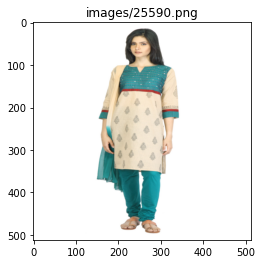

In [10]:
predict_genre_gender('images/25590.png')

Genre is Western
Gender is Male


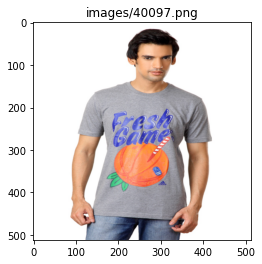

In [11]:
predict_genre_gender('images/40097.png')

Genre is Western
Gender is Female


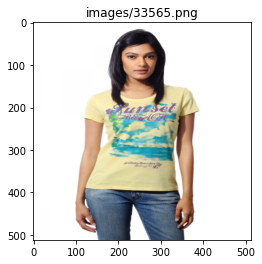

In [12]:
predict_genre_gender('images/33565.png')

Genre is Ethnic
Gender is Male


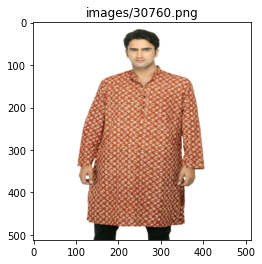

In [13]:
predict_genre_gender('images/30760.png')

Genre is Western
Gender is Female


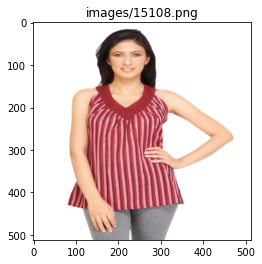

In [14]:
predict_genre_gender('images/15108.png')